依赖导入与设备检测

In [1]:
import warnings, time, json, copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import  os
   

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import flwr as fl
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE, "Flower:", fl.__version__)
warnings.filterwarnings("ignore", category=UserWarning, module="flwr")
os.environ["FLWR_TELEMETRY_ENABLED"] = "0"  # 关掉 Flower 统计

E:\python\anaconda\envs\dl-exp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-25 15:16:09,469	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Device: cuda Flower: 1.18.0


数据切分函数

In [2]:
def get_dataloaders(cid: int, num_clients: int, batch=32):
    tf = transforms.Compose([transforms.ToTensor(),
                             transforms.Normalize((0.1307,), (0.3081,))])
    mnist_tr = datasets.MNIST("data", train=True,  download=True, transform=tf)
    mnist_te = datasets.MNIST("data", train=False, download=True, transform=tf)

    shard = len(mnist_tr) // num_clients
    subset = Subset(mnist_tr, range(cid*shard, (cid+1)*shard))

    return (DataLoader(subset, batch, shuffle=True),
            DataLoader(mnist_te, 256, shuffle=False))


模型定义

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,3,1)
        self.conv2 = nn.Conv2d(32,64,3,1)
        self.fc1   = nn.Linear(9216,128)
        self.fc2   = nn.Linear(128,10)
    def forward(self,x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x,2)
        x = torch.flatten(x,1)
        x = nn.functional.relu(self.fc1(x))
        return self.fc2(x)


Flower 客户端工厂

In [4]:
NUM_CLIENTS = 5
LOCAL_EPOCH = 1
LR = 1e-3

class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid: int):
        self.cid = cid
        self.train_ld, self.test_ld = get_dataloaders(cid, NUM_CLIENTS)
        self.net = SimpleCNN().to(DEVICE)
        self.opt = optim.Adam(self.net.parameters(), lr=LR)

    # ------ required three methods ------
    def get_parameters(self, config=None):
        return [p.cpu().numpy() for p in self.net.state_dict().values()]

    def fit(self, parameters, config=None):
        self.set_parameters(parameters)
        self.net.train()
        for _ in range(LOCAL_EPOCH):
            for x,y in self.train_ld:
                x,y = x.to(DEVICE), y.to(DEVICE)
                loss = nn.CrossEntropyLoss()(self.net(x), y)
                self.opt.zero_grad(); loss.backward(); self.opt.step()
        return self.get_parameters(), len(self.train_ld.dataset), {}

    def evaluate(self, parameters, config=None):
        self.set_parameters(parameters)
        self.net.eval(); correct = 0; loss_sum = 0
        with torch.no_grad():
            for x,y in self.test_ld:
                x,y = x.to(DEVICE), y.to(DEVICE)
                out = self.net(x)
                loss_sum += nn.CrossEntropyLoss()(out,y).item()*x.size(0)
                correct  += (out.argmax(1)==y).sum().item()
        n = len(self.test_ld.dataset)
        return loss_sum/n, n, {"accuracy": correct/n}

    # helper
    def set_parameters(self, params):
        state = dict(zip(self.net.state_dict().keys(),
                         [torch.tensor(p) for p in params]))
        self.net.load_state_dict(state, strict=True)


自定义策略（保存每轮指标 & 最终权重）

In [7]:
# ---------- 客户端工厂 ----------
def client_fn(cid: str):
    return FlowerClient(int(cid)).to_client()   # 注意 to_client()

def agg_metrics(eval_metrics):
    """
    eval_metrics: list of (num_examples, metrics_dict)
    返回整体加权平均 accuracy
    """
    if not eval_metrics:                      # 边界保护
        return {"accuracy": 0.0}

    total_examples = sum(num for num, _ in eval_metrics)
    acc = sum(num * m["accuracy"] for num, m in eval_metrics) / total_examples
    return {"accuracy": acc}


# ---------- 自定义策略 ----------
class RecordFedAvg(fl.server.strategy.FedAvg):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hist_acc, self.hist_loss = [], []
        self.final_params = None

    def aggregate_evaluate(self, rnd, results, failures):
        agg_loss, metrics = super().aggregate_evaluate(rnd, results, failures)
        if agg_loss is not None:
            # metrics 已是 {"accuracy": …}，不会再 KeyError
            self.hist_loss.append(agg_loss)
            self.hist_acc.append(metrics["accuracy"])
        return agg_loss, metrics

    def aggregate_fit(self, rnd, results, failures):
        params, metrics = super().aggregate_fit(rnd, results, failures)
        if params is not None:
            self.final_params = params
        return params, metrics

# ---------- 实例化策略 ----------
strategy = RecordFedAvg(
    fraction_fit          = 1.0,
    fraction_evaluate     = 1.0,
    min_fit_clients       = NUM_CLIENTS,
    min_evaluate_clients  = NUM_CLIENTS,
    min_available_clients = NUM_CLIENTS,
    evaluate_metrics_aggregation_fn = agg_metrics,  # 把函数传进来
)


单机模拟

In [8]:
history = fl.simulation.start_simulation(
    client_fn       = client_fn,
    num_clients     = NUM_CLIENTS,
    config          = fl.server.ServerConfig(num_rounds=5),
    strategy        = strategy,
    client_resources={"num_cpus":1, "num_gpus":0.0},
)


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2025-05-25 15:20:49,907	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0, 'CPU': 20.0, 'memory': 4837355520.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 2418677760.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower

训练曲线

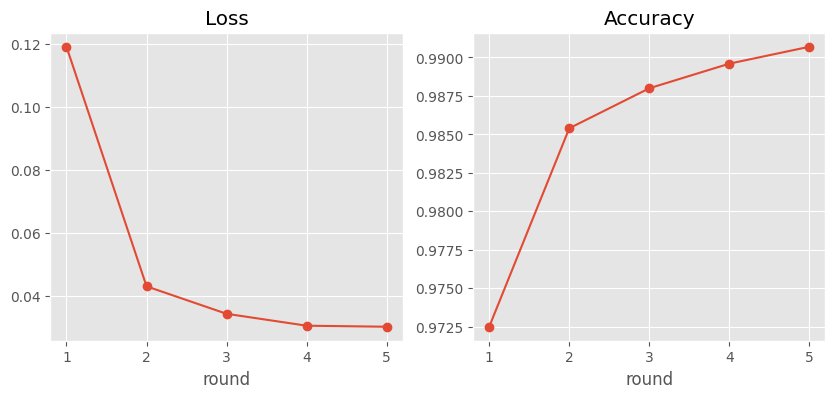

In [9]:
rnd = range(1, len(strategy.hist_acc)+1)
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(rnd, strategy.hist_loss, 'o-'); ax[0].set_title("Loss")
ax[1].plot(rnd, strategy.hist_acc,  'o-'); ax[1].set_title("Accuracy")
for a in ax: a.set_xlabel("round")
plt.show()


全局模型评估

In [11]:
from flwr.common import parameters_to_ndarrays   # ← NEW

# 1. 把 Parameters → list[np.ndarray]
ndarrays = parameters_to_ndarrays(strategy.final_params)

# 2. 组装成符合 state_dict 的格式
state = {k: torch.tensor(v) for k, v in zip(global_net.state_dict().keys(),
                                            ndarrays)}
global_net = SimpleCNN()
global_net.load_state_dict(state)
global_net.eval()


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Global test accuracy: 99.07%


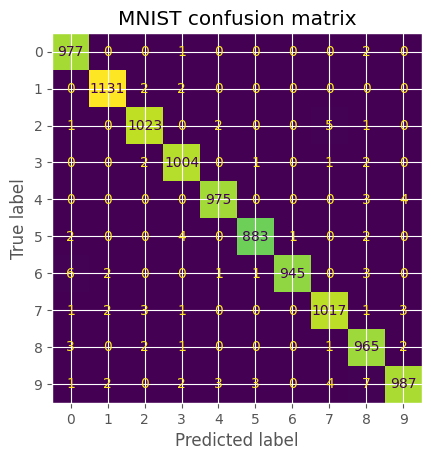

Macro ROC-AUC: 1.000


In [12]:
from flwr.common import parameters_to_ndarrays
import numpy as np, torch, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ---- 1. 载入 Flower 聚合后的权重 ----
ndarrays = parameters_to_ndarrays(strategy.final_params)   # 解包
global_net = SimpleCNN()
global_net.load_state_dict(
    {k: torch.tensor(v) for k, v in zip(global_net.state_dict().keys(), ndarrays)}
)
global_net.eval()

# ---- 2. 准备测试集 ----
tf = transforms.Compose([transforms.ToTensor(),
                         transforms.Normalize((0.1307,), (0.3081,))])
test_ds = datasets.MNIST("data", train=False, download=True, transform=tf)
test_ld = DataLoader(test_ds, 1024, shuffle=False)

# ---- 3. 推理收集预测 ----
y_true, y_prob = [], []
with torch.no_grad():
    for x, y in test_ld:
        probs = global_net(x).softmax(1)
        y_true.extend(y.numpy())
        y_prob.extend(probs.numpy())

y_prob = np.vstack(y_prob)
y_pred = y_prob.argmax(1)
acc = (y_pred == np.array(y_true)).mean()
print(f"Global test accuracy: {acc:.2%}")

# ---- 4. 可视化 ----
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot(colorbar=False)
plt.title("MNIST confusion matrix"); plt.show()

auc_macro = roc_auc_score(y_true, y_prob, multi_class="ovr")
print(f"Macro ROC-AUC: {auc_macro:.3f}")

